## This file filters the metadata

In [ ]:
params_file = None
input_file = None
output_file = None

In [ ]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None


In [ ]:
import json
with open(params_file) as f:
    data = json.load(f)
num_contributions = int(data['filter_metadata']['num_contributions'])
rating_thr = float(data['filter_metadata']['thr_rating'])

Index(['primary_label', 'secondary_labels', 'type', 'latitude', 'longitude',
       'scientific_name', 'common_name', 'author', 'license', 'rating', 'time',
       'url', 'filename'],
      dtype='object')


Text(0.5, 1.0, 'Sampling locations of original bird data')

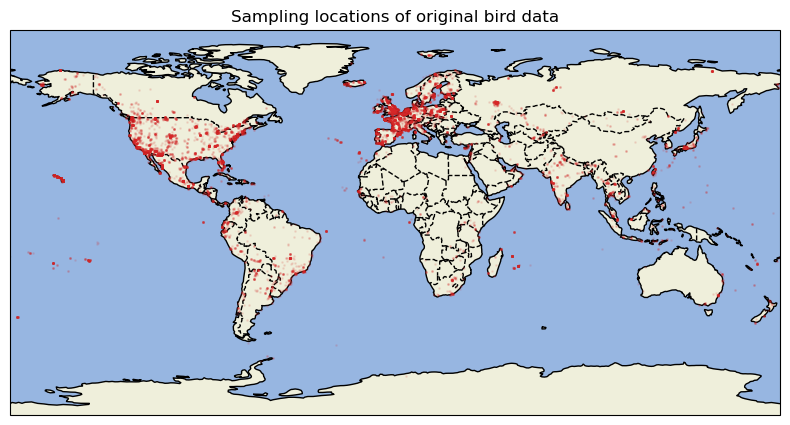

In [ ]:
meta = pd.read_csv(input_file)
meta.sort_values(by=['primary_label'], inplace=True)

# We will not use data from authors who don't have enough contributions
author_counts = meta['author'].value_counts()
uncommon_authors = author_counts[author_counts <= num_contributions].index.to_list()
print(f'Number of authors with less than {num_contributions} contributions: {len(uncommon_authors)}')
print(f'Number of authors with more than {num_contributions} contributions: {len(author_counts) - len(uncommon_authors)}')
print()
meta = meta[~meta['author'].isin(uncommon_authors)]

# We will not use data with poor sound quality
good_quality = meta['rating'] > rating_thr
poor_quality = meta['rating'] <= rating_thr
print(f'Number of samples with poor quality: {sum(poor_quality)}')
print(f'Number of samples with good quality: {sum(good_quality)}')
print()
meta = meta[good_quality]

# We will ignore data with missing or invalid time

# hour-based
meta['hour_str'] = meta['time'].apply(lambda x: x.split(':')[0])
hour_issues = ['.','x','?','??','xx','am','pm','xx.xx','Dawn','020']
hour_issue_indices = np.argwhere(meta['hour_str'].isin(hour_issues)).squeeze()
meta = meta[~meta['hour_str'].isin(hour_issues)]
meta['hour_int'] = meta['hour_str'].astype(int)

# minute-based
meta['minute_str'] = meta['time'].apply(lambda x: x.split(':')[1])
minute_issue_indices = np.argwhere(meta['minute_str'].apply(lambda x: x[2:]).isin(['am','pm'])).squeeze()
meta = meta[~meta['minute_str'].apply(lambda x: x[2:]).isin(['am','pm'])]
meta['minute_int'] = meta['minute_str'].astype(int)

# We will remove data when there are multiple species in the sound
num_species = meta['secondary_labels'].apply(lambda x: len(x.split(',')))
multiple_species = num_species > 1
print(f'Number of samples with multiple species: {sum(multiple_species)}')
meta = meta[~multiple_species]

# Save the cleaned metadata
meta.to_csv(output_file, index=False)
